In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-12 12:35:55.753275: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 12:35:55.780049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 12:35:56.319975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    # Limit the dataset to the first 20,000 rows
    train_data = train_data.select(range(20000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]

            # L1 regularization
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            
            # L2 regularization
            l2_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)

            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_amazon_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
1825367,Two Stars,To small,2,bad,2,train
120096,Four Stars,Good sweater fits nice and great special events,4,good,0,val
11223117,Very poor quality.,"The fabric is very stiff, cheap stuff. The lac...",2,bad,2,train
34791446,Nice dress!,"I love this this dress, the design, the color ...",4,good,0,val
29816062,I love America and I love tanks,I love America and I love tanks. I can't wait...,5,good,0,train
21023787,Five Stars,Love it,5,good,0,train
26381280,Is beautiful!,"Love this dress! Fabric is soft, looks beauti...",5,good,0,train
115135,Do not disappoint with it!,The dress came as expected time. I will wear f...,5,good,0,val
32352958,But it feels nice and looks great,I am petite (5'0&#34;) and wear between a 4 an...,4,good,0,train


In [6]:
df.groupby(['sentiment']).count()

,review_headline,review_body,star_rating,label,data_type
sentiment,,,,,
bad,3514,3514,3514,3514,3514
good,14664,14664,14664,14664,14664
neutral,1822,1822,1822,1822,1822


In [7]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(15975, 4025)

In [9]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 3

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(
            pretrained_gpt_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        bert_config = BertConfig.from_pretrained(pretrained_bert_path)
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [10]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Define the regularization strength
lambda_l1 = 0.001
lambda_l2 = 0.001
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddin

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 25
patience = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.340816298548976
Validation loss: 0.23079741980240215
F1 Score (weighted): 0.9128968335474179


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22353804428693042
Validation loss: 0.38235858919651944
F1 Score (weighted): 0.9078705386253427
34.41% Training loss decreased compared to the previous epoch
65.67% Validation loss increased compared to the previous epoch
0.55% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.16052100970465655
Validation loss: 0.3940758546060533
F1 Score (weighted): 0.910034924874205
28.19% Training loss decreased compared to the previous epoch
3.06% Validation loss increased compared to the previous epoch
0.24% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.10945657080488921
Validation loss: 0.51591134470611
F1 Score (weighted): 0.8993224144428901
31.81% Training loss decreased compared to the previous epoch
30.92% Validation loss increased compared to the previous epoch
1.18% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06788991418067515
Validation loss: 0.6387632939046671
F1 Score (weighted): 0.9083575856067718
37.98% Training loss decreased compared to the previous epoch
23.81% Validation loss increased compared to the previous epoch
1.0% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.054478194134291794
Validation loss: 0.6675483866411923
F1 Score (weighted): 0.9047124004211448
19.76% Training loss decreased compared to the previous epoch
4.51% Validation loss increased compared to the previous epoch
0.4% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 104.53212396303813 minutes
Final Accuracy: 0.9005006257822278
Final Precision: 0.9114942545120114


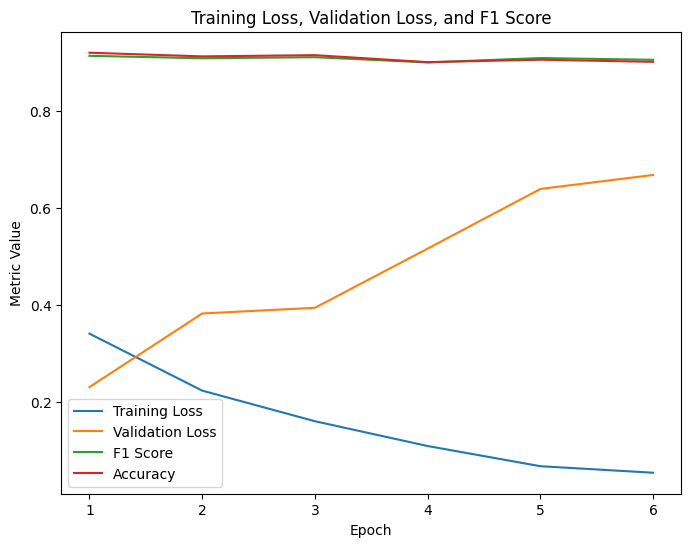

Epoch                 Training Loss         Validation Loss      F1 Score            Accuracy              Precision
--------------------  --------------------  -------------------  ------------------  ------------------  -----------
1                     0.340816298548976     0.23079741980240215  0.9128968335474179  0.9192740926157698     0.913644
2                     0.22353804428693042   0.38235858919651944  0.9078705386253427  0.9078705386253427     0.907871
3                     0.16052100970465655   0.3940758546060533   0.910034924874205   0.910034924874205      0.910035
4                     0.10945657080488921   0.51591134470611     0.8993224144428901  0.8993224144428901     0.899322
5                     0.06788991418067515   0.6387632939046671   0.9083575856067718  0.9083575856067718     0.908358
6                     0.054478194134291794  0.6675483866411923   0.9047124004211448  0.9047124004211448     0.904712
Total Training Time                                             

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.09713092846692241
Validation loss: 0.038050413491000655
F1 Score (weighted): 0.9918192941888407


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06264587996735763
Validation loss: 0.046544151443522426
F1 Score (weighted): 0.9893448649838951
35.5% Training loss decreased compared to the previous epoch
22.32% Validation loss increased compared to the previous epoch
0.25% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0405264111480357
Validation loss: 0.03534129262790884
F1 Score (weighted): 0.9931505411767088
35.31% Training loss decreased compared to the previous epoch
24.07% Validation loss decreased compared to the previous epoch
0.38% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.030971910058327886
Validation loss: 0.055897509326950964
F1 Score (weighted): 0.9919119532607368
23.58% Training loss decreased compared to the previous epoch
58.16% Validation loss increased compared to the previous epoch
0.12% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.024639630702694496
Validation loss: 0.06945428423285648
F1 Score (weighted): 0.9880025898467785
20.45% Training loss decreased compared to the previous epoch
24.25% Validation loss increased compared to the previous epoch
0.39% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.017670430181267276
Validation loss: 0.0924949705041945
F1 Score (weighted): 0.9868977824039832
28.28% Training loss decreased compared to the previous epoch
33.17% Validation loss increased compared to the previous epoch
0.11% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.013591700337032208
Validation loss: 0.048824872459670134
F1 Score (weighted): 0.9925535898973353
23.08% Training loss decreased compared to the previous epoch
47.21% Validation loss decreased compared to the previous epoch
0.57% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.008873839243111855
Validation loss: 0.07928890734330253
F1 Score (weighted): 0.9867957633654972
34.71% Training loss decreased compared to the previous epoch
62.39% Validation loss increased compared to the previous epoch
0.58% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 139.43685499429702 minutes
Final Accuracy: 0.9868585732165206
Final Precision: 0.9867620675101578


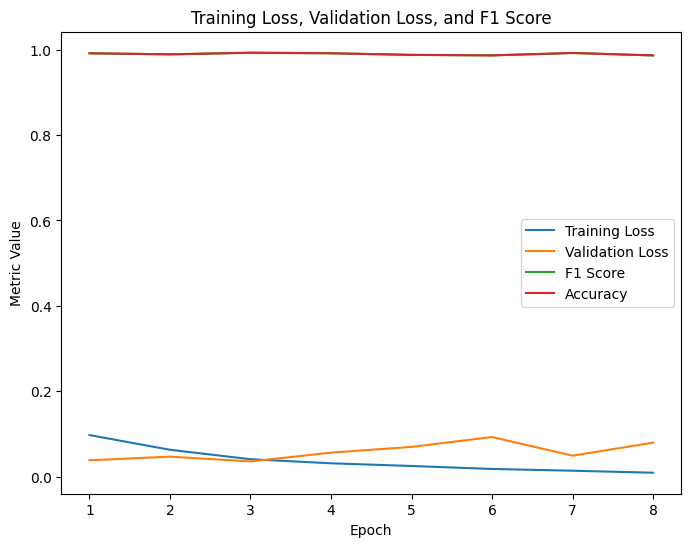

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.09713092846692241   0.038050413491000655  0.9918192941888407  0.9918648310387985     0.991811
2                     0.06264587996735763   0.046544151443522426  0.9893448649838951  0.9893448649838951     0.989345
3                     0.0405264111480357    0.03534129262790884   0.9931505411767088  0.9931505411767088     0.993151
4                     0.030971910058327886  0.055897509326950964  0.9919119532607368  0.9919119532607368     0.991912
5                     0.024639630702694496  0.06945428423285648   0.9880025898467785  0.9880025898467785     0.988003
6                     0.017670430181267276  0.0924949705041945    0.9868977824039832  0.9868977824039832     0.986898
7                     0.013591700337032208  0.0488248724

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.01780692769176761
Validation loss: 0.003740018135321179
F1 Score (weighted): 0.9981253015247005


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.010389798974454828
Validation loss: 0.004541308180837405
F1 Score (weighted): 0.9987514589527736
41.65% Training loss decreased compared to the previous epoch
21.42% Validation loss increased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0062885116266485205
Validation loss: 0.001133344059924184
F1 Score (weighted): 0.9993750090597125
39.47% Training loss decreased compared to the previous epoch
75.04% Validation loss decreased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.006734098795977484
Validation loss: 0.0033518531708148203
F1 Score (weighted): 0.9987514589527736
7.09% Training loss increased compared to the previous epoch
195.75% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.006050817895516161
Validation loss: 0.002187065110177855
F1 Score (weighted): 0.9993750090597125
10.15% Training loss decreased compared to the previous epoch
34.75% Validation loss decreased compared to the previous epoch
0.06% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.005133015948998733
Validation loss: 0.002762803964080831
F1 Score (weighted): 0.9987514589527736
15.17% Training loss decreased compared to the previous epoch
26.32% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0032551435298579677
Validation loss: 0.0024743289869650197
F1 Score (weighted): 0.9987514589527736
36.58% Training loss decreased compared to the previous epoch
10.44% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0019811878761333192
Validation loss: 0.004152295600656544
F1 Score (weighted): 0.9987514589527736
39.14% Training loss decreased compared to the previous epoch
67.82% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 139.3564819097519 minutes
Final Accuracy: 0.9987484355444305
Final Precision: 0.9987631598321431


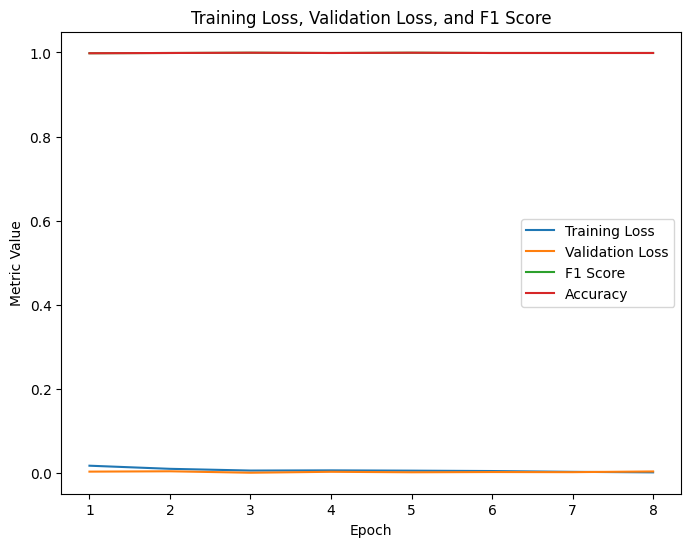

Epoch                 Training Loss          Validation Loss        F1 Score            Accuracy              Precision
--------------------  ---------------------  ---------------------  ------------------  ------------------  -----------
1                     0.01780692769176761    0.003740018135321179   0.9981253015247005  0.9981226533166458     0.99813
2                     0.010389798974454828   0.004541308180837405   0.9987514589527736  0.9987514589527736     0.998751
3                     0.0062885116266485205  0.001133344059924184   0.9993750090597125  0.9993750090597125     0.999375
4                     0.006734098795977484   0.0033518531708148203  0.9987514589527736  0.9987514589527736     0.998751
5                     0.006050817895516161   0.002187065110177855   0.9993750090597125  0.9993750090597125     0.999375
6                     0.005133015948998733   0.002762803964080831   0.9987514589527736  0.9987514589527736     0.998751
7                     0.00325514352985796

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.002183270299227312
Validation loss: 6.642902002340634e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0015698741305724263
Validation loss: 6.2125437122517725e-06
F1 Score (weighted): 1.0
28.1% Training loss decreased compared to the previous epoch
6.48% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0006648926793077187
Validation loss: 7.024324897599854e-06
F1 Score (weighted): 1.0
57.65% Training loss decreased compared to the previous epoch
13.07% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0017082740622257767
Validation loss: 6.3096218423197566e-06
F1 Score (weighted): 1.0
156.92% Training loss increased compared to the previous epoch
10.17% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0014343714200637727
Validation loss: 6.355954888022097e-06
F1 Score (weighted): 1.0
16.03% Training loss decreased compared to the previous epoch
0.73% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0004730742099816965
Validation loss: 6.2536997342022e-06
F1 Score (weighted): 1.0
67.02% Training loss decreased compared to the previous epoch
1.61% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0011443847216476312
Validation loss: 6.2528802121164515e-06
F1 Score (weighted): 1.0
141.9% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 121.89547904729844 minutes
Final Accuracy: 1.0
Final Precision: 1.0


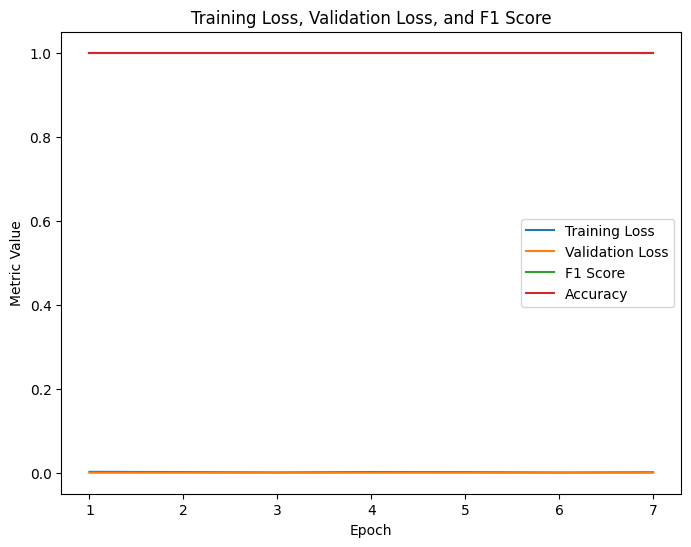

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.002183270299227312   6.642902002340634e-06   1.0         1.0               1
2                     0.0015698741305724263  6.2125437122517725e-06  1.0         1.0               1
3                     0.0006648926793077187  7.024324897599854e-06   1.0         1.0               1
4                     0.0017082740622257767  6.3096218423197566e-06  1.0         1.0               1
5                     0.0014343714200637727  6.355954888022097e-06   1.0         1.0               1
6                     0.0004730742099816965  6.2536997342022e-06     1.0         1.0               1
7                     0.0011443847216476312  6.2528802121164515e-06  1.0         1.0               1
Total Training Time                                                                

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0008431763172832293
Validation loss: 4.819678480629363e-05
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0005123901483627658
Validation loss: 4.819864761003601e-05
F1 Score (weighted): 1.0
39.23% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.00026684526748806055
Validation loss: 4.8196635918031914e-05
F1 Score (weighted): 1.0
47.92% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0016997575102619825
Validation loss: 4.819526981975741e-05
F1 Score (weighted): 1.0
536.98% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0015547395630519673
Validation loss: 4.819651173079364e-05
F1 Score (weighted): 1.0
8.53% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0005010932326980804
Validation loss: 4.819484766741766e-05
F1 Score (weighted): 1.0
67.77% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.000874804493680906
Validation loss: 4.820142897756341e-05
F1 Score (weighted): 1.0
74.58% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.002296317935835288
Validation loss: 4.821622931899583e-05
F1 Score (weighted): 1.0
162.49% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0005443402786692969
Validation loss: 4.819643712451693e-05
F1 Score (weighted): 1.0
76.3% Training loss decreased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0002692874391439877
Validation loss: 4.820674363031685e-05
F1 Score (weighted): 1.0
50.53% Training loss decreased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0007244176067835033
Validation loss: 4.8198946059585525e-05
F1 Score (weighted): 1.0
169.01% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 191.78576175371805 minutes
Final Accuracy: 1.0
Final Precision: 1.0


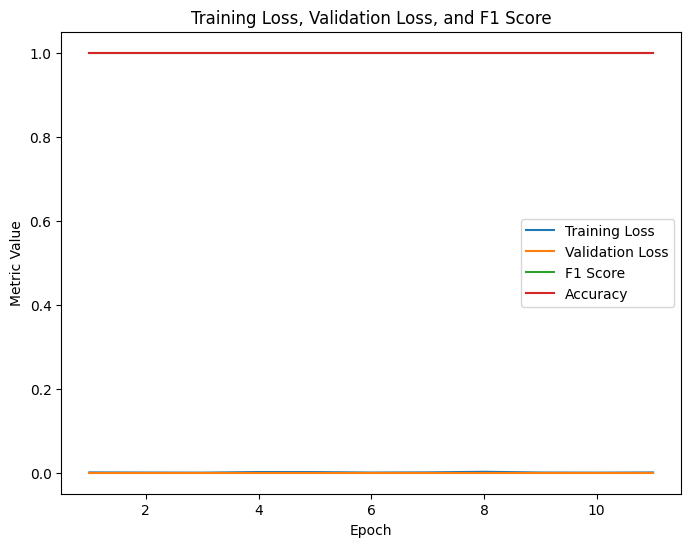

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0008431763172832293   4.819678480629363e-05   1.0         1.0               1
2                     0.0005123901483627658   4.819864761003601e-05   1.0         1.0               1
3                     0.00026684526748806055  4.8196635918031914e-05  1.0         1.0               1
4                     0.0016997575102619825   4.819526981975741e-05   1.0         1.0               1
5                     0.0015547395630519673   4.819651173079364e-05   1.0         1.0               1
6                     0.0005010932326980804   4.819484766741766e-05   1.0         1.0               1
7                     0.000874804493680906    4.820142897756341e-05   1.0         1.0               1
8                     0.002296317935835288    4.821622931899583e-05   1.0 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.00026443192905317166
Validation loss: 0.0017689454416893113
F1 Score (weighted): 0.9993729353562039


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0007036695711492581
Validation loss: 0.001768944503177181
F1 Score (weighted): 0.9993729353562039
166.11% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 3.508981749365053e-05
Validation loss: 0.0017689533093741261
F1 Score (weighted): 0.9993729353562039
95.01% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 2.962692913107241e-05
Validation loss: 0.0017689530856492297
F1 Score (weighted): 0.9993729353562039
15.57% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0005086499270845953
Validation loss: 0.0017689536076889566
F1 Score (weighted): 0.9993729353562039
1616.85% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0006529001489289426
Validation loss: 0.0017689429084404651
F1 Score (weighted): 0.9993729353562039
28.36% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0004921538663194124
Validation loss: 0.0017689432513353154
F1 Score (weighted): 0.9993729353562039
24.62% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0007722567358589259
Validation loss: 0.001768940062511888
F1 Score (weighted): 0.9993729353562039
56.91% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.000555990981378451
Validation loss: 0.0017689427151370296
F1 Score (weighted): 0.9993729353562039
28.0% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0011162485553127272
Validation loss: 0.001768953340772157
F1 Score (weighted): 0.9993729353562039
100.77% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0001599893051284537
Validation loss: 0.0017689412394145164
F1 Score (weighted): 0.9993729353562039
85.67% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.00038652395971122894
Validation loss: 0.0017689425658184632
F1 Score (weighted): 0.9993729353562039
141.59% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0006429461672089147
Validation loss: 0.0017689388254501636
F1 Score (weighted): 0.9993729353562039
66.34% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0009254230366091125
Validation loss: 0.0017689380957978075
F1 Score (weighted): 0.9993729353562039
43.93% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0009393546462692595
Validation loss: 0.0017689461865984413
F1 Score (weighted): 0.9993729353562039
1.51% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 16
Training loss: 8.271905576029823e-05
Validation loss: 0.0017689476471409193
F1 Score (weighted): 0.9993729353562039
91.19% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.0008599362565599235
Validation loss: 0.0017689396750728292
F1 Score (weighted): 0.9993729353562039
939.59% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.0001302374256951108
Validation loss: 0.0017689406582775292
F1 Score (weighted): 0.9993729353562039
84.85% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.0012582419226874575
Validation loss: 0.0017689466037924717
F1 Score (weighted): 0.9993729353562039
866.11% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 331.45798532565436 minutes
Final Accuracy: 0.9993738259236068
Final Precision: 0.9993743694774925


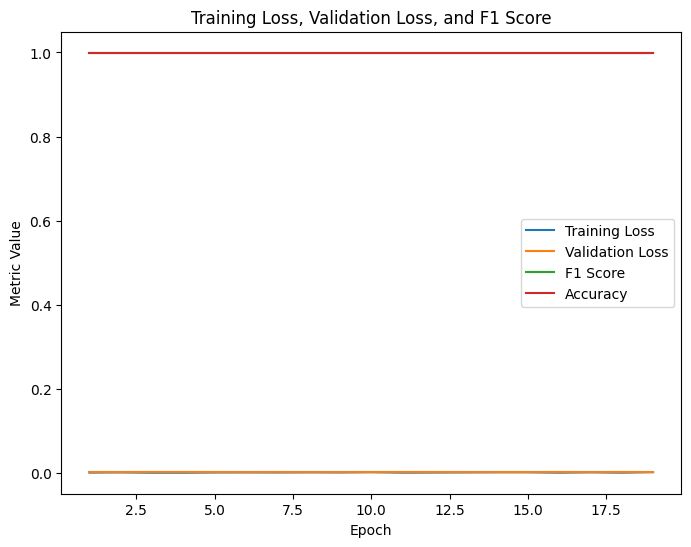

Epoch                 Training Loss           Validation Loss        F1 Score            Accuracy               Precision
--------------------  ----------------------  ---------------------  ------------------  ------------------  ------------
1                     0.00026443192905317166  0.0017689454416893113  0.9993729353562039  0.9993738259236068      0.999374
2                     0.0007036695711492581   0.001768944503177181   0.9993729353562039  0.9993729353562039      0.999373
3                     3.508981749365053e-05   0.0017689533093741261  0.9993729353562039  0.9993729353562039      0.999373
4                     2.962692913107241e-05   0.0017689530856492297  0.9993729353562039  0.9993729353562039      0.999373
5                     0.0005086499270845953   0.0017689536076889566  0.9993729353562039  0.9993729353562039      0.999373
6                     0.0006529001489289426   0.0017689429084404651  0.9993729353562039  0.9993729353562039      0.999373
7                     0.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0005095982022419789
Validation loss: 5.258999476325243e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0005630220857447775
Validation loss: 5.253545690493411e-06
F1 Score (weighted): 1.0
10.48% Training loss increased compared to the previous epoch
0.1% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0007094649387911813
Validation loss: 5.2516234239874394e-06
F1 Score (weighted): 1.0
26.01% Training loss increased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.000920469064909767
Validation loss: 5.2542162492841275e-06
F1 Score (weighted): 1.0
29.74% Training loss increased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0007842910991688135
Validation loss: 5.273661788294248e-06
F1 Score (weighted): 1.0
14.79% Training loss decreased compared to the previous epoch
0.37% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0005659432171325719
Validation loss: 5.292927981486173e-06
F1 Score (weighted): 1.0
27.84% Training loss decreased compared to the previous epoch
0.37% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0005007012977517086
Validation loss: 5.264453220377163e-06
F1 Score (weighted): 1.0
11.53% Training loss decreased compared to the previous epoch
0.54% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.00022266523307620724
Validation loss: 5.251981070841793e-06
F1 Score (weighted): 1.0
55.53% Training loss decreased compared to the previous epoch
0.24% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 139.533837334315 minutes
Final Accuracy: 1.0
Final Precision: 1.0


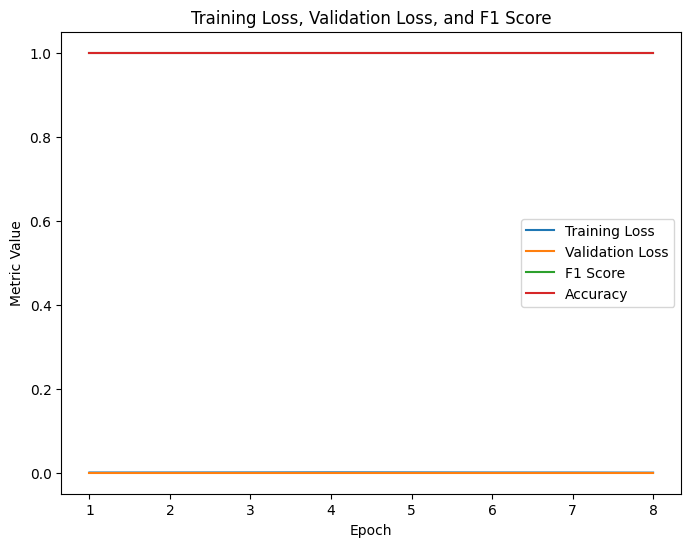

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0005095982022419789   5.258999476325243e-06   1.0         1.0               1
2                     0.0005630220857447775   5.253545690493411e-06   1.0         1.0               1
3                     0.0007094649387911813   5.2516234239874394e-06  1.0         1.0               1
4                     0.000920469064909767    5.2542162492841275e-06  1.0         1.0               1
5                     0.0007842910991688135   5.273661788294248e-06   1.0         1.0               1
6                     0.0005659432171325719   5.292927981486173e-06   1.0         1.0               1
7                     0.0005007012977517086   5.264453220377163e-06   1.0         1.0               1
8                     0.00022266523307620724  5.251981070841793e-06   1.0 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0008484517684329114
Validation loss: 4.679344597775526e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0021436405344537686
Validation loss: 4.687122893756168e-06
F1 Score (weighted): 1.0
152.65% Training loss increased compared to the previous epoch
0.17% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.001850842647286742
Validation loss: 4.673801384171838e-06
F1 Score (weighted): 1.0
13.66% Training loss decreased compared to the previous epoch
0.28% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0004749632945646928
Validation loss: 4.6739354974079105e-06
F1 Score (weighted): 1.0
74.34% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0009258439031029281
Validation loss: 4.684977187423556e-06
F1 Score (weighted): 1.0
94.93% Training loss increased compared to the previous epoch
0.24% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0009800053442425652
Validation loss: 4.679389315640492e-06
F1 Score (weighted): 1.0
5.85% Training loss increased compared to the previous epoch
0.12% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0005226247411057536
Validation loss: 4.6789422958681825e-06
F1 Score (weighted): 1.0
46.67% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0011955833260590277
Validation loss: 4.676438896922263e-06
F1 Score (weighted): 1.0
128.77% Training loss increased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 139.4408993045489 minutes
Final Accuracy: 1.0
Final Precision: 1.0


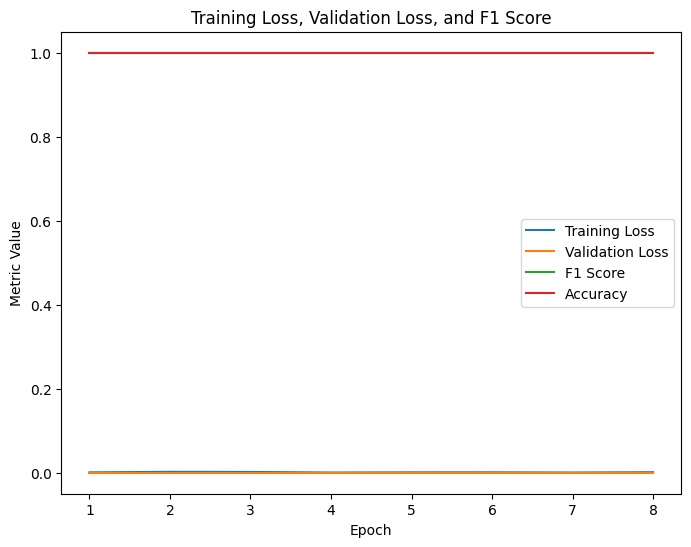

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.0008484517684329114  4.679344597775526e-06   1.0         1.0               1
2                     0.0021436405344537686  4.687122893756168e-06   1.0         1.0               1
3                     0.001850842647286742   4.673801384171838e-06   1.0         1.0               1
4                     0.0004749632945646928  4.6739354974079105e-06  1.0         1.0               1
5                     0.0009258439031029281  4.684977187423556e-06   1.0         1.0               1
6                     0.0009800053442425652  4.679389315640492e-06   1.0         1.0               1
7                     0.0005226247411057536  4.6789422958681825e-06  1.0         1.0               1
8                     0.0011955833260590277  4.676438896922263e-06   1.0         1.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0005180821207250802
Validation loss: 4.6225548817346864e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0005867792462030718
Validation loss: 4.619962096228392e-06
F1 Score (weighted): 1.0
13.26% Training loss increased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0012059190166994463
Validation loss: 4.62403006764589e-06
F1 Score (weighted): 1.0
105.51% Training loss increased compared to the previous epoch
0.09% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00045884439660265087
Validation loss: 4.620945559281609e-06
F1 Score (weighted): 1.0
61.95% Training loss decreased compared to the previous epoch
0.07% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0004461583361723652
Validation loss: 4.624566524285001e-06
F1 Score (weighted): 1.0
2.76% Training loss decreased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/1798 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0008171022400191738
Validation loss: 4.62362774584335e-06
F1 Score (weighted): 1.0
83.14% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/1798 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_val = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # train_model(trainer, dataloader_train, dataloader_val, epochs, patience)

    try:
        train_model(trainer, dataloader_train, dataloader_val, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

In [ ]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

In [ ]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_train)
accuracy_per_class(predictions, true_vals)